<a href="https://colab.research.google.com/github/spencer18001/machine-learning-zoomcamp/blob/main/08/hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%%capture
!pip install tqdm xgboost
!wget -O jamb_exam_results.csv https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error
from tqdm.auto import tqdm
import xgboost as xgb

In [3]:
df_path = "jamb_exam_results.csv"
df = pd.read_csv(df_path)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [4]:
df.shape

(5000, 17)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
del df["student_id"]
df.fillna(0, inplace=True)

In [7]:
df.dtypes

,0
jamb_score,int64
study_hours_per_week,int64
attendance_rate,int64
teacher_quality,int64
distance_to_school,float64
school_type,object
school_location,object
extra_tutorials,object
access_to_learning_materials,object
parent_involvement,object


In [8]:
def data_split(df, random_state):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

In [9]:
df_train, df_val, df_test = data_split(df, random_state=1)
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

In [10]:
def one_hot_encode(df, dv, train):
    feature_dict = df.iloc[:, 1:].to_dict(orient='records')
    if train == True:
        X = dv.fit_transform(feature_dict)
    else:
        X = dv.transform(feature_dict)
    return X

In [11]:
def decision_tree_reg_fit(df, max_depth, dv):
    X = one_hot_encode(df, dv, train=True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X, df.iloc[:, 0].values)
    return model

In [12]:
dv = DictVectorizer(sparse=False)

In [13]:
dt_model = decision_tree_reg_fit(df_train, max_depth=1, dv=dv)

In [14]:
feature_names = list(dv.get_feature_names_out())
print(feature_names[dt_model.tree_.feature[0]]) # Q1
print(export_text(dt_model, feature_names=feature_names))

study_hours_per_week
|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [15]:
def random_forest_reg_fit(df, n_estimators, max_depth, random_state, dv):
    X = one_hot_encode(df, dv, train=True)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
    model.fit(X, df.iloc[:, 0].values)
    return model

In [16]:
def random_forest_reg_predict(model, df, dv):
    X = one_hot_encode(df, dv, train=False)
    y_pred = model.predict(X)
    return y_pred

In [17]:
rf_model = random_forest_reg_fit(df_train, n_estimators=10, max_depth=None, random_state=1, dv=dv)
y_pred = random_forest_reg_predict(rf_model, df_val, dv=dv)
root_mean_squared_error(df_val.iloc[:, 0], y_pred) # Q2

42.13724207871227

  0%|          | 0/20 [00:00<?, ?it/s]

(90,
 {10: 42.13724207871227,
  20: 41.46121464694444,
  30: 41.106170947924596,
  40: 40.917193933296545,
  50: 40.852278663496854,
  60: 40.78428140159447,
  70: 40.677098222414024,
  80: 40.53933283129176,
  90: 40.50434592594835,
  100: 40.51680451861919,
  110: 40.59335280539747,
  120: 40.6248503681005,
  130: 40.650840905587195,
  140: 40.5948515491302,
  150: 40.596715029667116,
  160: 40.60350763548252,
  170: 40.62754627591216,
  180: 40.641313925139386,
  190: 40.63135509073867,
  200: 40.60101912236933})

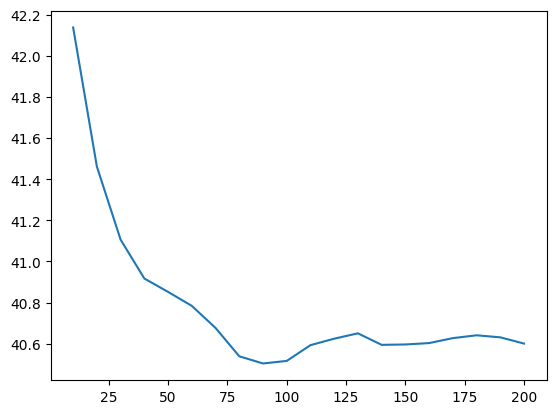

In [18]:
n_estimators_list = range(10, 201, 10)
rmse_list = []
for n_estimators in tqdm(n_estimators_list):
    rf_model = random_forest_reg_fit(df_train, n_estimators=n_estimators, max_depth=None, random_state=1, dv=dv)
    y_pred = random_forest_reg_predict(rf_model, df_val, dv=dv)
    rmse_list.append(root_mean_squared_error(df_val.iloc[:, 0], y_pred))

plt.plot(n_estimators_list, rmse_list)
n_estimators_list[np.argmin(rmse_list)], dict(zip(n_estimators_list, rmse_list)) # Q3

In [19]:
max_depth_list = [10, 15, 20, 25]
n_estimators_list = range(10, 201, 10)
mean_rmse_list = []
for max_depth in tqdm(max_depth_list):
    rmse_list = []
    for n_estimators in n_estimators_list:
        rf_model = random_forest_reg_fit(df_train, n_estimators=n_estimators, max_depth=max_depth, random_state=1, dv=dv)
        y_pred = random_forest_reg_predict(rf_model, df_val, dv=dv)
        rmse_list.append(root_mean_squared_error(df_val.iloc[:, 0], y_pred))
    mean_rmse_list.append(np.mean(rmse_list))

max_depth_list[np.argmin(mean_rmse_list)], dict(zip(max_depth_list, mean_rmse_list)) # Q4

  0%|          | 0/4 [00:00<?, ?it/s]

(10,
 {10: 40.39249798892396,
  15: 40.73528172486332,
  20: 40.739734321829275,
  25: 40.78786565962805})

In [22]:
rf_model = random_forest_reg_fit(df_train, n_estimators=10, max_depth=20, random_state=1, dv=dv)
feature_names[np.argmax(rf_model.feature_importances_)], rf_model.feature_importances_ # Q5

('study_hours_per_week',
 array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
        0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
        0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
        0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
        0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
        0.01070798, 0.01056268, 0.24835361, 0.08268222]))

In [26]:
def xgboost_fit(df_train, df_val, xgb_params, num_boost_round, dv):
    feature_names=list(dv.get_feature_names_out())
    X_train = one_hot_encode(df_train, dv, train=True)
    dtrain = xgb.DMatrix(X_train, label=df_train.iloc[:, 0], feature_names=feature_names)
    X_val = one_hot_encode(df_val, dv, train=False)
    dval = xgb.DMatrix(X_val, label=df_val.iloc[:, 0], feature_names=feature_names)
    model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round, evals=[(dtrain, 'train'), (dval, 'val')])
    return model

In [27]:
def xgboost_predict(model, df, dv):
    X = one_hot_encode(df, dv, train=False)
    data = xgb.DMatrix(X, label=df.iloc[:, 0], feature_names=list(dv.get_feature_names_out()))
    y_pred = model.predict(data)
    return y_pred

In [28]:
eta_list = [0.3, 0.1]
rmse_list = []
for eta in eta_list:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    xgb_model = xgboost_fit(df_train, df_val, xgb_params, 100, dv)
    y_pred = xgboost_predict(xgb_model, df_val, dv)
    rmse = root_mean_squared_error(df_val.iloc[:, 0], y_pred)
    rmse_list.append(rmse)

eta_list[np.argmin(rmse_list)], dict(zip(eta_list, rmse_list)) # Q6

[0]	train-rmse:42.69552	val-rmse:44.86028
[1]	train-rmse:39.85005	val-rmse:43.06070
[2]	train-rmse:37.95285	val-rmse:41.83772
[3]	train-rmse:36.52203	val-rmse:41.26987
[4]	train-rmse:35.36066	val-rmse:41.02965
[5]	train-rmse:34.43646	val-rmse:40.87186
[6]	train-rmse:33.71528	val-rmse:40.69132
[7]	train-rmse:33.07449	val-rmse:40.65074
[8]	train-rmse:32.41772	val-rmse:40.72710
[9]	train-rmse:31.91000	val-rmse:40.82972
[10]	train-rmse:31.55119	val-rmse:40.83684
[11]	train-rmse:30.99534	val-rmse:40.98243
[12]	train-rmse:30.33163	val-rmse:41.05515
[13]	train-rmse:30.04347	val-rmse:41.18635
[14]	train-rmse:29.44279	val-rmse:41.32160
[15]	train-rmse:29.08791	val-rmse:41.37832
[16]	train-rmse:28.84106	val-rmse:41.45737
[17]	train-rmse:28.28883	val-rmse:41.51113
[18]	train-rmse:27.90071	val-rmse:41.55139
[19]	train-rmse:27.60694	val-rmse:41.66496
[20]	train-rmse:27.24424	val-rmse:41.80313
[21]	train-rmse:26.79013	val-rmse:41.88767
[22]	train-rmse:26.64232	val-rmse:41.90488
[23]	train-rmse:26.31

(0.1, {0.3: 44.432098039002526, 0.1: 41.043354592351655})